## Declarations

In [1]:
import torch

In [2]:
device = torch.device('cuda')

In [3]:
batch_size = 32

In [4]:
learning_rate = 0.001

## Merge Data Directories

In [5]:
import shutil
from glob import glob
import os


In [6]:
for f in glob(r'D:\temp\muz-tree\libimage\*'):
    for ff in glob(os.path.join(f, '*')):
        shutil.move(ff, r'D:\temp\muz-tree\merge')

## Create Dataset

In [7]:
from torchvision.datasets import ImageFolder

In [8]:
import torchvision.transforms as T

In [9]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=360),
  T.RandomHorizontalFlip(),
  T.RandomVerticalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [10]:
dataset = ImageFolder(r'D:\temp\muz-tree\merge', transforms['train'])

In [11]:
dataset_sizes = {d: len(dataset) for d in ['train', 'val', 'test']}

In [12]:
def collate_fn(b):
#     x = torch.stack([torch.tensor(np.array(x[0], dtype=np.float32), dtype=torch.float32) for x in b])
    x = torch.stack([im[0] for im in b]).float()
    y = torch.stack([torch.tensor(a[1], dtype=torch.int64) for a in b]).long()
    return x, y

In [13]:
dl = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn)

In [14]:
data_loaders = {d: dl for d in ['train', 'val', 'test']}

In [15]:
b = next(iter(dl))

In [16]:
b[0].shape, b[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

## Create Model

In [17]:
from torchvision.models import resnet34

In [18]:
model = resnet34(True)

In [19]:
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))

In [20]:
model = model.to(device)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training 

In [22]:
from torch import nn, optim
from torch.optim import lr_scheduler
from collections import defaultdict
import numpy as np

In [23]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for inputs, labels in data_loader:        
        print(' .', end='')
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in data_loader:    
            print(' .', end='')
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(
          model,
          data_loaders['train'],
          loss_fn,
          optimizer,
          device,
          scheduler,
          dataset_sizes['train']
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(
          model,
          data_loaders['val'],
          loss_fn,
          device,
          dataset_sizes['val']
        )
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
    print(f'Best val accuracy: {best_accuracy}')
    model.load_state_dict(torch.load('best_model_state.bin'))
    return model, history

In [26]:
c = 0
cyc = 3
while True:
    print('\n\n')
    c+=cyc
    m = f"v1_{c}e"    
    print(f"-- Training model {m}")
    model, history = train_model(model, data_loaders, dataset_sizes, device, cyc)
    torch.save(model, f'./models/{m}.pth')




-- Training model v1_3e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 6.234227363099444 accuracy 0.002677376171352075
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 6.044310062489611 accuracy 0.004016064257028112

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 6.052861173102197 accuracy 0.002677376171352075
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 5.922373680358238 accuracy 0.00535475234270415

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 5.936399632311882 accuracy 0.004685408299866131
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 5.820850625951239 accuracy 0.0147255689

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 1.613082299841211 accuracy 0.822623828647925
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 1.1158072187545451 accuracy 0.8895582329317269

Best val accuracy: 0.8895582329317269



-- Training model v1_51e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 1.5674216798011293 accuracy 0.824631860776439
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 1.073623775167668 accuracy 0.8821954484605087

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 1.50331774671027 accuracy 0.8400267737617135
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 1.057253103306953 accuracy 0.89

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.5410908454276145 accuracy 0.9451137884872824
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.2914642869157994 accuracy 0.965194109772423

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.5002676984097095 accuracy 0.9538152610441767
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.2734872321499155 accuracy 0.9712182061579652

Best val accuracy: 0.9712182061579652



-- Training model v1_99e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.49952313367356643 accuracy 0.9444444444444444
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.24712814929637503 accur

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.18634392479632764 accuracy 0.9765729585006693

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.3679859013633525 accuracy 0.9625167336010709
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.18752373342818401 accuracy 0.9825970548862115

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.3681810697976579 accuracy 0.9578313253012047
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.17887685368669795 accuracy 0.9819277108433735

Best val accuracy: 0.9825970548862115



-- Training model v1_123e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.29659763676054934 accuracy 0.966532797858099
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.1490640199564873 accuracy 0.9825970548862115

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.24681898951530457 accuracy 0.9752342704149932
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.12457297100348676 accuracy 0.9872824631860776

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.2764574295662819 accuracy 0.9692101740294511
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.14087949780390618 accuracy 0.9792503346720214

Best val accuracy: 0.9872824631860776




Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.19653318029768924 accuracy 0.9825970548862115
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.10002954645042723 accuracy 0.9886211512717537

Best val accuracy: 0.9892904953145917



-- Training model v1_192e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.21566077876598277 accuracy 0.9779116465863453
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.09217540412507158 accuracy 0.9859437751004015

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.21133872422766178 accuracy 0.9705488621151271
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   los

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.08745275374422683 accuracy 0.9839357429718875

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.15909979761915005 accuracy 0.9852744310575635
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.06965940033501768 accuracy 0.9912985274431058

Best val accuracy: 0.9912985274431058



-- Training model v1_216e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.17556343528818577 accuracy 0.9792503346720214
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.08545836140500739 accuracy 0.9872824631860776

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train lo

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.1543015644271323 accuracy 0.9819277108433735
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.07900919749381695 accuracy 0.9899598393574297

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.15357385908669613 accuracy 0.9866131191432396
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.07781476674086237 accuracy 0.9872824631860776

Best val accuracy: 0.9899598393574297



-- Training model v1_240e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.16287319330458946 accuracy 0.9779116465863453
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.06360041342200116 accuracy 0.9919678714859438

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.1371387962965255 accuracy 0.9879518072289156
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.05333801836488729 accuracy 0.9939759036144578

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.13145550356266347 accuracy 0.9832663989290495
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.059335821486533956 accuracy 0.9933065595716197

Best val accuracy: 0.9939759036144578



-- Training model v1_264e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train lo




-- Training model v1_285e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.11894719524586454 accuracy 0.9886211512717537
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.07110924955378188 accuracy 0.9879518072289156

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.12274869166790171 accuracy 0.9819277108433735
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.05584738752309312 accuracy 0.9926372155287817

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.11628264664335454 accuracy 0.9892904953145917
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.0571421225495795 accuracy 0.991298

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.06006496032065851 accuracy 0.9892904953145917

Best val accuracy: 0.9946452476572958



-- Training model v1_309e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.1148259956785973 accuracy 0.9859437751004015
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.06281872569246495 accuracy 0.9886211512717537

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.12557689401697605 accuracy 0.9825970548862115
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.050544211205015795 accuracy 0.9912985274431058

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train lo

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.11041282719754159 accuracy 0.9852744310575635
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.04221706452997441 accuracy 0.9926372155287817

Best val accuracy: 0.9966532797858099



-- Training model v1_333e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.09455626125031329 accuracy 0.9919678714859438
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.046619551870575614 accuracy 0.9926372155287817

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.11094320517905215 accuracy 0.9872824631860776
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.0515385829903026

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.043132630592965064 accuracy 0.9939759036144578

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.09825961735654384 accuracy 0.9846050870147255
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.04647324581016252 accuracy 0.9939759036144578

Best val accuracy: 0.9953145917001338



-- Training model v1_357e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.10215052027017513 accuracy 0.9899598393574297
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.03906329166381917 accuracy 0.9919678714859438

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train l

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.08629671785425633 accuracy 0.9926372155287817
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.037657195414872245 accuracy 0.9939759036144578

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.09157969216082959 accuracy 0.9892904953145917
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.04610327991874928 accuracy 0.9906291834002677

Best val accuracy: 0.9939759036144578



-- Training model v1_381e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.08209004744570306 accuracy 0.9886211512717537
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   lo

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.025187998772301573 accuracy 0.9966532797858099

Best val accuracy: 0.9966532797858099



-- Training model v1_426e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.0793538973369497 accuracy 0.9872824631860776
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.03523300710986269 accuracy 0.9919678714859438

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.08103413927428266 accuracy 0.9892904953145917
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.03436223124252989 accuracy 0.9946452476572958

Epoch 3/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train lo

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.08469376213690068 accuracy 0.9859437751004015
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.028977413562701105 accuracy 0.9973226238286479

Best val accuracy: 0.9973226238286479



-- Training model v1_450e
Epoch 1/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.07012518253573712 accuracy 0.9912985274431058
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.03628912052892624 accuracy 0.9926372155287817

Epoch 2/3
----------
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Train loss 0.07409403615809501 accuracy 0.9886211512717537
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Val   loss 0.0296259408301495

KeyboardInterrupt: 

## Convert to torchscript

In [36]:
ex = dataset[0][0][None].cuda()

In [37]:
traced = torch.jit.trace(model, ex)

In [38]:
traced

ResNet(
  original_name=ResNet
  (conv1): Conv2d(original_name=Conv2d)
  (bn1): BatchNorm2d(original_name=BatchNorm2d)
  (relu): ReLU(original_name=ReLU)
  (maxpool): MaxPool2d(original_name=MaxPool2d)
  (layer1): Sequential(
    original_name=Sequential
    (0): BasicBlock(
      original_name=BasicBlock
      (conv1): Conv2d(original_name=Conv2d)
      (bn1): BatchNorm2d(original_name=BatchNorm2d)
      (relu): ReLU(original_name=ReLU)
      (conv2): Conv2d(original_name=Conv2d)
      (bn2): BatchNorm2d(original_name=BatchNorm2d)
    )
    (1): BasicBlock(
      original_name=BasicBlock
      (conv1): Conv2d(original_name=Conv2d)
      (bn1): BatchNorm2d(original_name=BatchNorm2d)
      (relu): ReLU(original_name=ReLU)
      (conv2): Conv2d(original_name=Conv2d)
      (bn2): BatchNorm2d(original_name=BatchNorm2d)
    )
    (2): BasicBlock(
      original_name=BasicBlock
      (conv1): Conv2d(original_name=Conv2d)
      (bn1): BatchNorm2d(original_name=BatchNorm2d)
      (relu): ReLU(

In [40]:
f'./models/{m}.pt'

'./models/v1_465e.pt'

In [41]:
traced.save(f'./models/{m}.pt')

## Preview Results

In [47]:
from PIL import Image

In [105]:
im = Image.open(r'D:\temp\muz-tree\merge\Cordia myxa\C. myxa leaf + fruit.jpg')

In [162]:
p = r'C:/Users/san10428/Downloads/OIP (2).jfif'

In [163]:
im = Image.open(p)

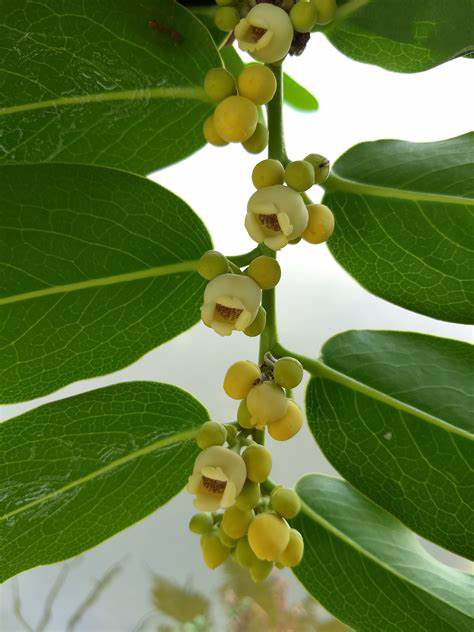

In [164]:
im

In [174]:
%%time
with torch.no_grad():
    im_tfm = dataset.transform(im)[None]
    conf = model.cpu().eval()(im_tfm.cpu())

Wall time: 315 ms


In [166]:
# with torch.no_grad():
#     im_tfm = dataset.transform(im)
#     conf = traced(im_tfm[None].cuda()).cpu()

In [167]:
conf.argmax()

tensor(406, device='cuda:0')

In [169]:
dataset.classes[406]

'Zizyphus jujuba'

In [170]:
conf

tensor([[-3.1210e+00, -8.2009e-01, -1.0124e+00, -2.8038e+00, -3.4123e+00,
         -3.0190e+00, -5.4690e-01, -1.7929e-01, -4.9900e+00, -2.6189e+00,
         -2.2395e+00, -1.0505e+00, -2.1212e-02,  7.1559e+00, -4.2895e+00,
          6.9494e+00, -1.5640e+00, -2.5986e+00, -3.1949e-01,  2.8563e+00,
         -4.2318e+00, -1.5647e+00, -5.4362e+00, -2.7842e-01, -3.1744e+00,
         -4.6982e+00, -2.7772e+00, -2.0905e+00,  3.3851e+00,  1.9899e-02,
         -2.7276e+00,  2.9920e+00,  8.4229e+00,  4.4114e+00,  6.7987e+00,
          9.8948e-01, -1.9703e+00,  3.1716e+00, -3.4623e+00, -2.7951e+00,
         -3.3858e+00, -3.0210e+00, -1.9546e+00, -2.8589e+00, -4.6467e+00,
         -2.5814e+00,  2.9192e+00, -2.9364e+00,  1.5344e+00,  5.3418e+00,
          9.6852e-02,  2.3261e+00,  2.5519e-01,  1.0352e+00, -3.3364e-01,
          7.9614e-01, -3.8523e+00,  2.4021e+00,  5.1945e-01,  1.6553e+00,
          1.6242e+00,  2.7763e+00,  2.2115e+00, -3.5847e-02, -1.9611e+00,
         -2.6523e+00, -1.5501e+00, -4.

In [112]:
conf.shape

torch.Size([1, 408])